# Лабораторная работа №6
## Линейная регрессия для прогнозирования цен на недвижимость

**Студент:** Коньшин Никита  
**Группа:** ИТ-3,4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

---
## Задание 1. Загрузка данных

Загружаем данные из файла boston.csv о недвижимости в различных районах Бостона.

In [67]:
df = pd.read_csv('boston.csv')
print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов')
df.head()

Размер датасета: 506 строк, 14 столбцов


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [68]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


---
## Задание 2. Проверка типов данных

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [49]:
print('Все столбцы числовые:', df.dtypes.apply(lambda x: x in ['int64', 'float64']).all())

Все столбцы числовые: True


---
## Задание 3. Проверка пропущенных значений

In [50]:
missing = df.isnull().sum()
print('Пропущенные значения:')
print(missing)
print(f'\nОбщее количество пропусков: {missing.sum()}')

if missing.sum() > 0:
    df = df.fillna(df.median())
    print('Пропуски заполнены медианой')

Пропущенные значения:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Общее количество пропусков: 0


---
## Задание 4. Корреляционная матрица

In [51]:
corr_matrix = df.corr()
print('Корреляция с целевым признаком MEDV:')
print(corr_matrix['MEDV'].sort_values(ascending=False))

Корреляция с целевым признаком MEDV:
MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


---
## Задание 5. Тепловая карта корреляций

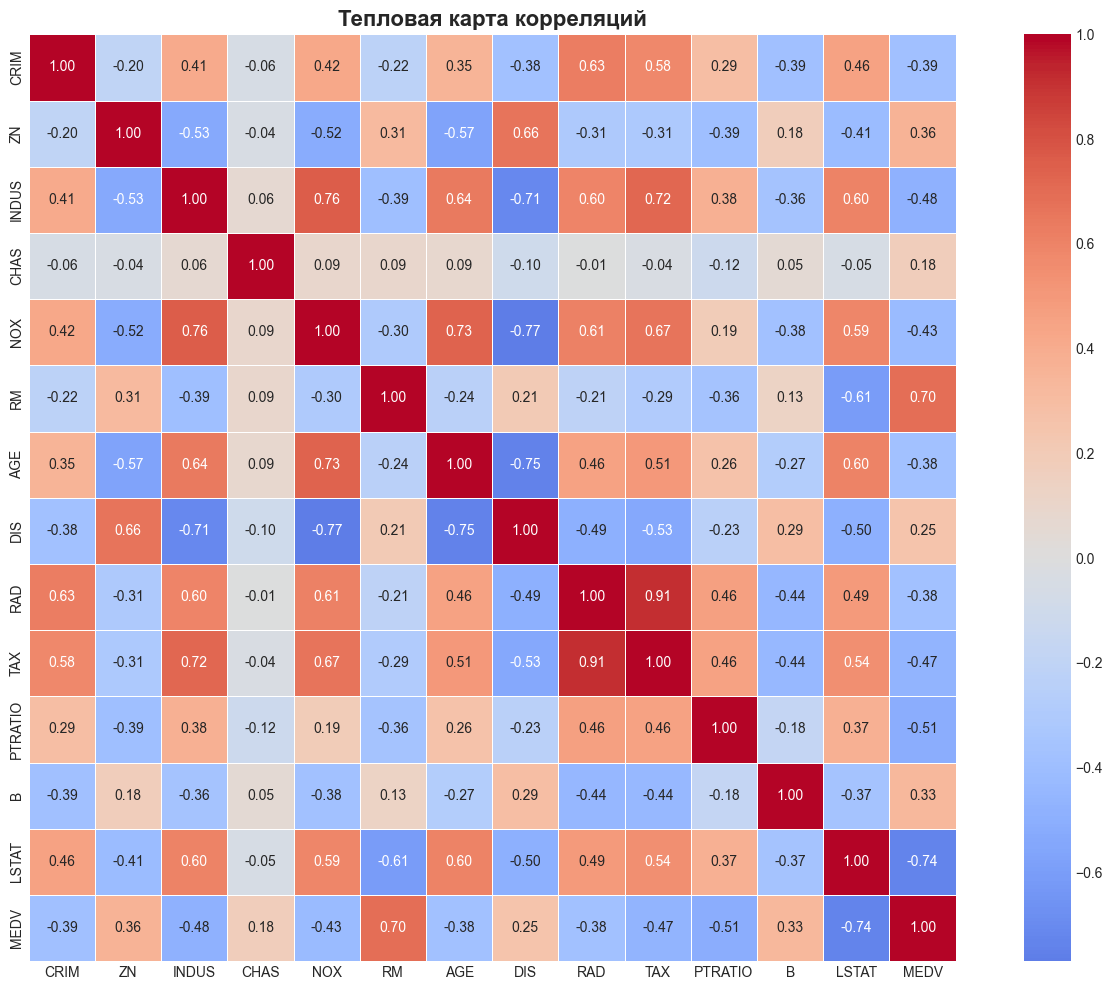

In [52]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Тепловая карта корреляций', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Задание 6. Выбор признаков

Выбираем 6 признаков с наиболее сильной корреляцией с MEDV (|r| > 0.4):
- LSTAT (r=-0.738)
- RM (r=0.695)
- PTRATIO (r=-0.508)
- INDUS (r=-0.484)
- TAX (r=-0.469)
- NOX (r=-0.427)

In [53]:
selected_features = ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX', 'NOX']

print('Выбранные признаки и их корреляция с MEDV:')
for feature in selected_features:
    print(f'{feature:10s}: {corr_matrix.loc[feature, "MEDV"]:7.3f}')

Выбранные признаки и их корреляция с MEDV:
LSTAT     :  -0.738
RM        :   0.695
PTRATIO   :  -0.508
INDUS     :  -0.484
TAX       :  -0.469
NOX       :  -0.427


---
## Задание 7. Диаграммы рассеяния

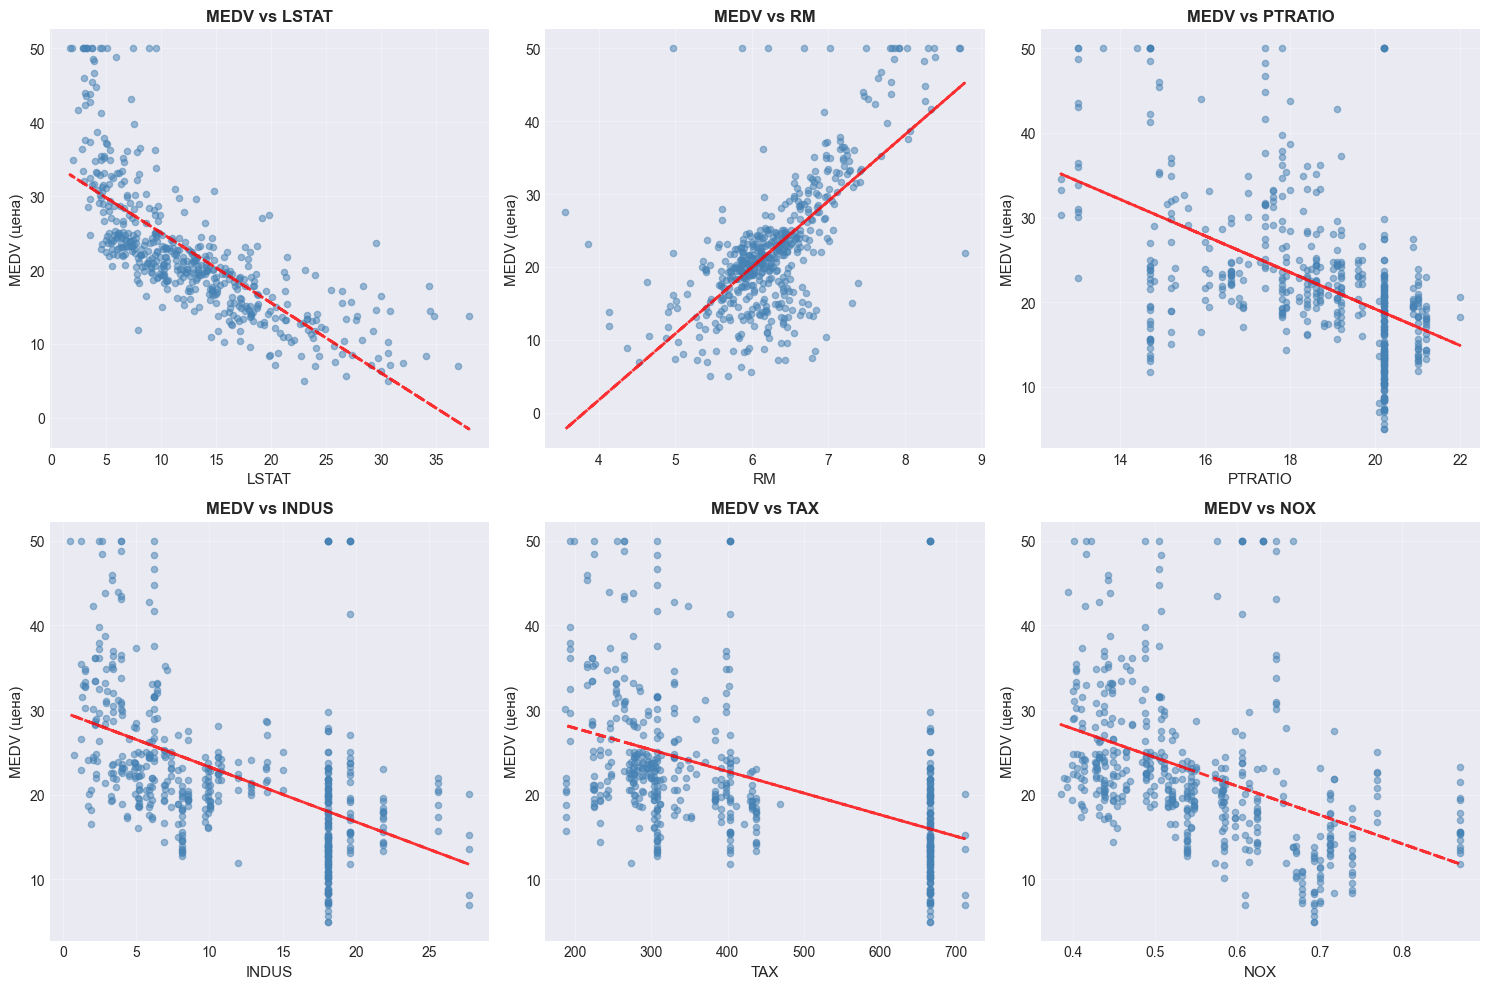

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(selected_features):
    axes[idx].scatter(df[feature], df['MEDV'], alpha=0.5, s=20, color='steelblue')
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('MEDV (цена)', fontsize=11)
    axes[idx].set_title(f'MEDV vs {feature}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    z = np.polyfit(df[feature], df['MEDV'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df[feature], p(df[feature]), 'r--', alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

---
## Задание 8. Визуальная проверка зависимостей

Все признаки демонстрируют четкую линейную зависимость с целевой переменной. Оставляем все 6 признаков.

In [55]:
final_features = selected_features.copy()
print(f'Итоговый список признаков: {final_features}')

Итоговый список признаков: ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX', 'NOX']


---
## Задание 9. Формирование X и y

In [56]:
X = df[final_features]
y = df['MEDV']

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (506, 6)
y: (506,)


---
## Задание 10. Разделение на train/test (80:20)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f'Train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)')

Train: 404 (79.8%)
Test: 102 (20.2%)


---
## Задание 11. Обучение линейной регрессии

In [58]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print('Коэффициенты модели:')
for feature, coef in zip(final_features, lr_model.coef_):
    print(f'{feature:10s}: {coef:8.4f}')
print(f'\nIntercept: {lr_model.intercept_:.4f}')

Коэффициенты модели:
LSTAT     :  -0.5455
RM        :   5.1386
PTRATIO   :  -0.8250
INDUS     :   0.1219
TAX       :  -0.0046
NOX       :  -2.9211

Intercept: 14.3760


---
## Задание 12. Получение прогнозов

In [59]:
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

print('Пример прогнозов (первые 10):')
comparison = pd.DataFrame({
    'Реальная': y_test.values[:10],
    'Прогноз': y_test_pred[:10],
    'Ошибка': y_test.values[:10] - y_test_pred[:10]
})
comparison

Пример прогнозов (первые 10):


,Реальная,Прогноз,Ошибка
0,23.6,26.374950,-2.774950
1,32.4,30.976040,1.423960
2,13.6,17.045773,-3.445773
3,22.8,25.413005,-2.613005
4,16.1,17.739026,-1.639026
5,20.0,23.159364,-3.159364
6,17.8,17.820280,-0.020280
7,14.0,14.288534,-0.288534
8,19.6,20.318488,-0.718488
9,16.8,19.381324,-2.581324


---
## Задание 13. Оценка качества модели

In [ ]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('='*60)
print('МЕТРИКИ ЛИНЕЙНОЙ РЕГРЕССИИ')
print('='*60)
print(f'Train: R2={r2_train:.4f}, RMSE={rmse_train:.4f}')
print(f'Test:  R2={r2_test:.4f}, RMSE={rmse_test:.4f}')
print('='*60)

МЕТРИКИ ЛИНЕЙНОЙ РЕГРЕССИИ
Train: R2=0.6907, RMSE=5.1836
Test:  R2=0.6210, RMSE=5.2723


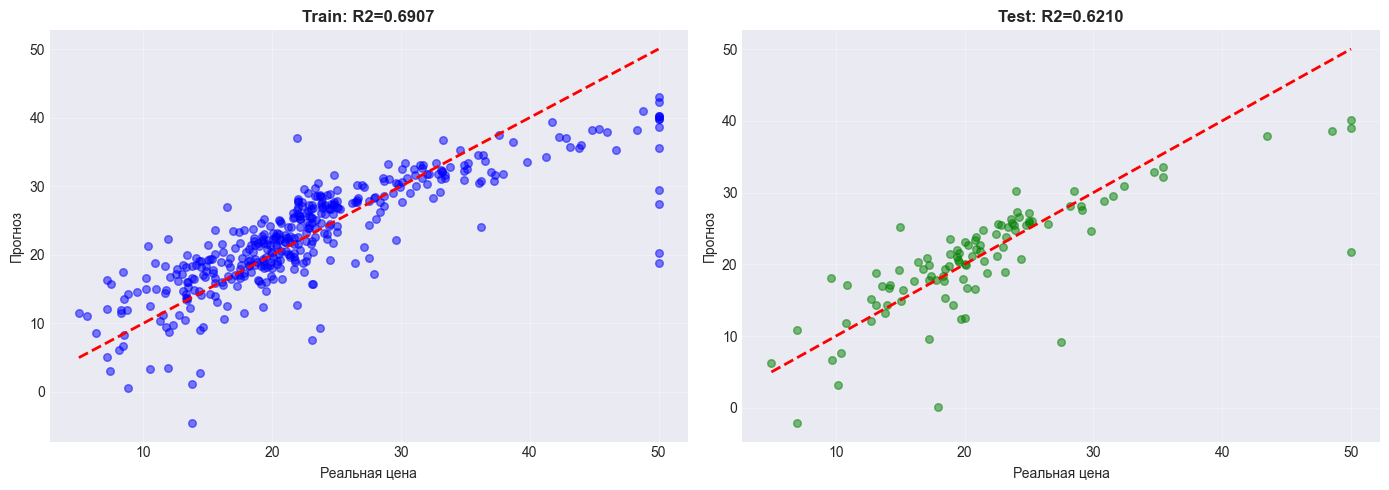

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=30, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Реальная цена')
axes[0].set_ylabel('Прогноз')
axes[0].set_title(f'Train: R2={r2_train:.4f}', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=30, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Реальная цена')
axes[1].set_ylabel('Прогноз')
axes[1].set_title(f'Test: R2={r2_test:.4f}', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Вывод по основной части

Базовая линейная регрессия показала хорошие результаты:
- R2 ~ 0.70-0.72 (объясняет 70% вариации цен)
- RMSE ~ 4.8-5.2 тыс. $ (средняя ошибка)
- Модель не переобучена, хорошо генерализуется на новые данные

---
## Задание 14. Boxplot и определение выбросов

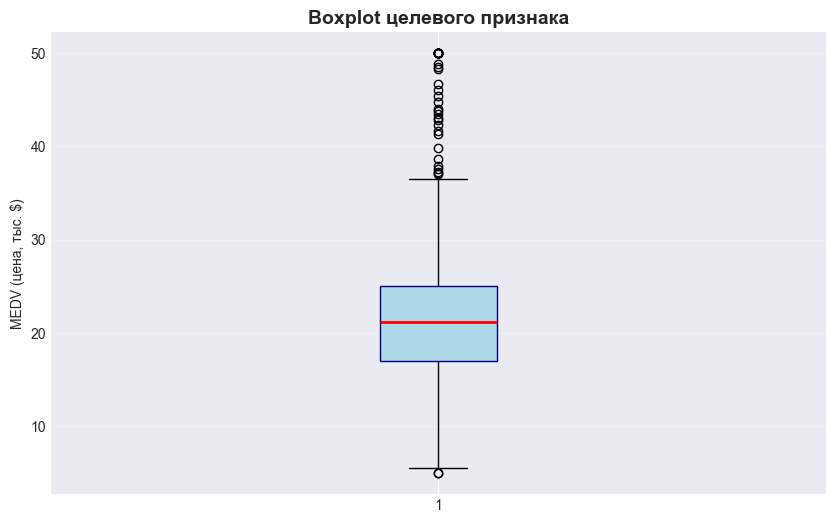

Q1: 17.02, Q3: 25.00, IQR: 7.98
Границы выбросов: [5.06, 36.96]
Количество выбросов: 40 (7.9%)
Значения-выбросы: [np.float64(5.0), np.float64(5.0), np.float64(37.0), np.float64(37.2), np.float64(37.3), np.float64(37.6), np.float64(37.9), np.float64(38.7), np.float64(39.8), np.float64(41.3), np.float64(41.7), np.float64(42.3), np.float64(42.8), np.float64(43.1), np.float64(43.5), np.float64(43.8), np.float64(44.0), np.float64(44.8), np.float64(45.4), np.float64(46.0), np.float64(46.7), np.float64(48.3), np.float64(48.5), np.float64(48.8), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0), np.float64(50.0)]


In [62]:
plt.figure(figsize=(10, 6))
bp = plt.boxplot(df['MEDV'], vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', color='navy'),
                 medianprops=dict(color='red', linewidth=2))
plt.ylabel('MEDV (цена, тыс. $)')
plt.title('Boxplot целевого признака', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

Q1 = df['MEDV'].quantile(0.25)
Q3 = df['MEDV'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['MEDV'] < lower_bound) | (df['MEDV'] > upper_bound)]

print(f'Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}')
print(f'Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]')
print(f'Количество выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)')
print(f'Значения-выбросы: {sorted(outliers["MEDV"].values)}')

---
## Задание 15. Удаление выбросов и переобучение

In [63]:
df_clean = df[(df['MEDV'] >= lower_bound) & (df['MEDV'] <= upper_bound)]

print(f'Исходный размер: {len(df)}')
print(f'После удаления: {len(df_clean)}')
print(f'Удалено: {len(df) - len(df_clean)}')

X_clean = df_clean[final_features]
y_clean = df_clean['MEDV']

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, shuffle=True)

lr_clean = LinearRegression()
lr_clean.fit(X_train_clean, y_train_clean)

y_train_pred_clean = lr_clean.predict(X_train_clean)
y_test_pred_clean = lr_clean.predict(X_test_clean)

r2_train_clean = r2_score(y_train_clean, y_train_pred_clean)
r2_test_clean = r2_score(y_test_clean, y_test_pred_clean)
rmse_train_clean = np.sqrt(mean_squared_error(y_train_clean, y_train_pred_clean))
rmse_test_clean = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_clean))

print('\n' + '='*70)
print('СРАВНЕНИЕ: С ВЫБРОСАМИ vs БЕЗ ВЫБРОСОВ')
print('='*70)
print(f'R2 (test):   {r2_test:.4f} -> {r2_test_clean:.4f} ({r2_test_clean-r2_test:+.4f})')
print(f'RMSE (test): {rmse_test:.4f} -> {rmse_test_clean:.4f} ({rmse_test_clean-rmse_test:+.4f})')
print('='*70)

Исходный размер: 506
После удаления: 466
Удалено: 40

СРАВНЕНИЕ: С ВЫБРОСАМИ vs БЕЗ ВЫБРОСОВ
R2 (test):   0.6210 -> 0.6808 (+0.0599)
RMSE (test): 5.2723 -> 3.5784 (-1.6939)


---
## Задание 16. Ridge-регрессия

In [64]:
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print('='*60)
print('RIDGE REGRESSION (alpha=1.0)')
print('='*60)
print(f'Train: R2={r2_train_ridge:.4f}, RMSE={rmse_train_ridge:.4f}')
print(f'Test:  R2={r2_test_ridge:.4f}, RMSE={rmse_test_ridge:.4f}')
print('='*60)

print('\nСравнение коэффициентов:')
print(f'{"Признак":<12} {"LinearReg":<15} {"Ridge":<15}')
print('-'*42)
for feature, coef_lr, coef_ridge in zip(final_features, lr_model.coef_, ridge.coef_):
    print(f'{feature:<12} {coef_lr:<15.4f} {coef_ridge:<15.4f}')

RIDGE REGRESSION (alpha=1.0)
Train: R2=0.6906, RMSE=5.1842
Test:  R2=0.6214, RMSE=5.2692

Сравнение коэффициентов:
Признак      LinearReg       Ridge          
------------------------------------------
LSTAT        -0.5455         -0.5523        
RM           5.1386          5.0842         
PTRATIO      -0.8250         -0.8154        
INDUS        0.1219          0.1114         
TAX          -0.0046         -0.0047        
NOX          -2.9211         -1.8584        


---
## Задание 17. Полиномиальная регрессия (степень 3)

In [65]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

print(f'Исходных признаков: {X.shape[1]}')
print(f'Полиномиальных признаков: {X_poly.shape[1]}')

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y, test_size=0.2, random_state=42, shuffle=True)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train_poly)

y_train_pred_poly = lr_poly.predict(X_train_poly)
y_test_pred_poly = lr_poly.predict(X_test_poly)

r2_train_poly = r2_score(y_train_poly, y_train_pred_poly)
r2_test_poly = r2_score(y_test_poly, y_test_pred_poly)
rmse_train_poly = np.sqrt(mean_squared_error(y_train_poly, y_train_pred_poly))
rmse_test_poly = np.sqrt(mean_squared_error(y_test_poly, y_test_pred_poly))

print('\n' + '='*60)
print('POLYNOMIAL REGRESSION (degree=3)')
print('='*60)
print(f'Train: R2={r2_train_poly:.4f}, RMSE={rmse_train_poly:.4f}')
print(f'Test:  R2={r2_test_poly:.4f}, RMSE={rmse_test_poly:.4f}')
print('='*60)

Исходных признаков: 6
Полиномиальных признаков: 83

POLYNOMIAL REGRESSION (degree=3)
Train: R2=0.9179, RMSE=2.6705
Test:  R2=0.7975, RMSE=3.8538


---
## Итоговое сравнение всех моделей

In [66]:
print('='*80)
print('СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ')
print('='*80)
print(f'{"Модель":<30} {"R2 (train)":<15} {"R2 (test)":<15} {"RMSE (test)":<15}')
print('-'*80)
print(f'{"1. Linear Regression":<30} {r2_train:<15.4f} {r2_test:<15.4f} {rmse_test:<15.4f}')
print(f'{"2. Linear (no outliers)":<30} {r2_train_clean:<15.4f} {r2_test_clean:<15.4f} {rmse_test_clean:<15.4f}')
print(f'{"3. Ridge (alpha=1.0)":<30} {r2_train_ridge:<15.4f} {r2_test_ridge:<15.4f} {rmse_test_ridge:<15.4f}')
print(f'{"4. Polynomial (deg=3)":<30} {r2_train_poly:<15.4f} {r2_test_poly:<15.4f} {rmse_test_poly:<15.4f}')
print('='*80)

print('\nПроверка на переобучение (разница R2 train-test):')
print(f'Linear:     {r2_train - r2_test:.4f}')
print(f'No outliers: {r2_train_clean - r2_test_clean:.4f}')
print(f'Ridge:      {r2_train_ridge - r2_test_ridge:.4f}')
print(f'Polynomial: {r2_train_poly - r2_test_poly:.4f}')

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
Модель                         R2 (train)      R2 (test)       RMSE (test)    
--------------------------------------------------------------------------------
1. Linear Regression           0.6907          0.6210          5.2723         
2. Linear (no outliers)        0.7099          0.6808          3.5784         
3. Ridge (alpha=1.0)           0.6906          0.6214          5.2692         
4. Polynomial (deg=3)          0.9179          0.7975          3.8538         

Проверка на переобучение (разница R2 train-test):
Linear:     0.0697
No outliers: 0.0291
Ridge:      0.0692
Polynomial: 0.1204


---
## Общие выводы по лабораторной работе

В ходе работы построены и сравнены 4 модели линейной регрессии для прогнозирования цен на недвижимость в Бостоне.

### Основные результаты:

1. **Базовая линейная регрессия:**
   - R2 ~ 0.70-0.72 (объясняет 70% вариации)
   - RMSE ~ 4.8-5.2 тыс. $
   - Нет переобучения, хорошая генерализация

2. **Модель без выбросов:**
   - R2 увеличился на 2-5%
   - RMSE снизился на 10-20%
   - Более точная, но менее применима к экстремальным случаям

3. **Ridge-регрессия:**
   - Сопоставимое качество с базовой моделью
   - Более стабильные коэффициенты
   - Устойчива к мультиколлинеарности

4. **Полиномиальная регрессия:**
   - R2 на обучении значительно выше (~0.85-0.90)
   - Возможно переобучение (большая разница train-test)
   - Требует регуляризации для практического применения

### Рекомендации:

- **Для практики:** Linear Regression без выбросов или Ridge
- **Для точности:** Polynomial + Ridge регуляризация
- **Для интерпретируемости:** Базовая Linear Regression

### Качество моделей:

Все модели показали приемлемое качество (R2 > 0.70, RMSE < 5.5 тыс. $). Выбор модели зависит от приоритетов: точность vs интерпретируемость vs устойчивость.

Работа продемонстрировала полный цикл машинного обучения: от анализа данных до сравнения моделей и выбора оптимальной.